<a name="top"></a><img src="./source/SpinalHDL.png" alt="SpinalHDL based on Scala" style="width:320px;" />

  Before running Spinal HDL code, be sure to load SpinalHDL Libraries  
**Note** : This may be a little slow when the first time load, please wait a moment to download Lib from remote.)

In [ ]:
val path = System.getProperty("user.dir") + "/source/load-spinal.sc"
interp.load.module(ammonite.ops.Path(java.nio.file.FileSystems.getDefault().getPath(path)))

## Assignment
- **:=** Standard assignment, equivalent to ‘<=’ in VHDL/Verilog :<br>the last assignment to a variable wins,<br>the value is not updated until the next simulation delta cycle
- **\\=** Equivalent to := in VHDL and = in Verilog<br>the value is updated instantly
- **<>** Automatic connection between 2 signals or two bundles of the same type.<br>Direction is inferred by using signal direction 

SpinalHDL checks that there are no combinatorial loops (latches) in your design. If one is detected, it raises an error and SpinalHDL will print the path of the loop.

####  Connection

In [ ]:
class Top extends Component{
 val a,b,c = UInt(4 bits)
 a := 0
 b := a
 c := a
}
showRtl(new Top)

In [ ]:
class Top extends Component{
  var x = UInt(4 bits)
  val y,z = UInt(4 bits)
  x := 0
  y := x      //y read x with the value 0
  x \= x + 1
  z := x      //z read x with the value 1
}
showRtl(new Top)

#### declare data type

In [ ]:
class Top extends Component{
val a = UInt(4 bits) //Define a combinatorial signal
val b = Reg(UInt(4 bits)) //Define a registered signal
val c = Reg(UInt(4 bits)) init(0) //Define a registered signal which is set to 0 when a reset occurs
}
showRtl(new Top)

#### width match check

In [ ]:
class Top extends Component{
    val x = in UInt(10 bits)
    val y = out UInt(8 bits)
    val z,z1 = out UInt()
    y := x.resized
    z := x.resize(4)
    z1 := x.resize(12)
    
    val a = in SInt(8 bits)
    val b = out SInt(16 bits)
    b := a.resized
}
showRtl(new Top)

#### constant assigment

In [ ]:
class Top extends Component{
    val y,z = out UInt(8 bits)
    val a,b = out SInt(8 bits)
    y := U(3)
    z := 3  
    a := S(-3)
    b := -3
}
showRtl(new Top)

## Branch(When/Switch/Mux)

#### conditional branch

In [ ]:
//When 
class Top extends Component{
    val cond1,cond2= in Bool()
    val dout = out UInt(8 bits)
  when(cond1){
      dout := 11
  //execute when      cond1 is true
  }.elsewhen(cond2){
      dout := 23
  //execute when (not cond1) and cond2
  }.otherwise{
      dout := 51
  //execute when (not cond1) and (not cond2)
  }
}
showRtl(new Top)

#### case branch 
A complete case statement generate by the spinalddl switch  
The switch generated in chisel is replaced by if else. Although there is no problem in function, but it is not very good-looking.

In [ ]:
//Switch 
class Top extends Component{
 val x = in UInt(2 bits)
 val dout = out UInt(8 bits)
 switch(x){
  is(0){
    //execute when x === value1
    dout := 11
  }
  is(1){
    //execute when x === value2
    dout := 23
  }
  default{
    //execute if none of precedent condition meet
    dout := 51
  }
 }
}
showRtl(new Top)

#### Mux, cond Expression

In [ ]:
//Mux cond? 
class Top extends Component{
val cond = in Bool()
val muxOutput,muxOutput2 = out UInt(8 bits)
 muxOutput  := Mux(cond, U(33,8 bits), U(51, 8 bits))
 muxOutput2 := cond ? U(22,8 bits) | U(49, 8 bits)
}
showRtl(new Top)

#### sel.mux Expression

In [ ]:
//mux
class Top extends Component{
    val io = new Bundle{
        val src0,src1 = in Bool()
    }
  val bitwiseSelect = UInt(2 bits)
  val bitwiseResult = bitwiseSelect.mux(
   0 -> (io.src0 & io.src1),
   1 -> (io.src0 | io.src1),
   2 -> (io.src0 ^ io.src1),
   default -> (io.src0)
  )
}
showRtl(new Top)

#### sel.mux expression， subdivideIn function
`muxLists(...)` is another bitwise selection which take as input a sequence of tuples.   
Below an example of dividing a Bits of 128 bits into 32 bits:
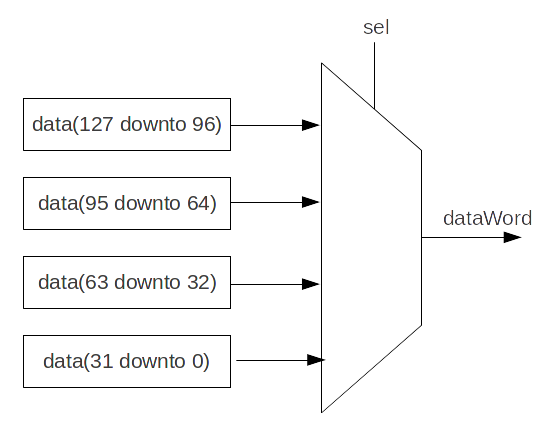

In [ ]:
//mux
class Top extends Component{
  val sel  = in UInt(2 bits)
  val data = in Bits(128 bits)
  val dataWord = sel.muxList(for(index <- 0 until 4) yield (index, data(index*32+32-1 downto index*32)))
  // This example can be written shorter.
  val dataWord2 = data.subdivideIn(32 bits)(sel)
}
showRtl(new Top)

## Rules

In [ ]:
class Top extends Component{
val a, b, c = UInt(8 bits) // Define 3 combinatorial signals
  c := a + b   // c will be set to 7
  b := 2       // b will be set to 2
  a := b + 3   // a will be set to 5
}
showRtl(new Top)

In [ ]:
class Top extends Component{
val x, y = Bool()             //Define two combinatorial signals
val result = UInt(8 bits)   //Define a combinatorial signal

result := 1
when(x){
  result := 2
  when(y){
    result := 3
  }
}
}
showRtl(new Top)

In [ ]:
class Top extends Component{
val inc, clear = Bool()            //Define two combinatorial signal/wire
val counter = Reg(UInt(8 bits))  //Define a 8 bits register

when(inc){
  counter := counter + 1
}
when(clear){
  counter := 0    //If inc and clear are True, then this  assignement wins (Last valid assignement rule)
}
}
showRtl(new Top)

Package operations as methods improve abstract ability

In [ ]:
class Top extends Component{
    val inc, clear = Bool()
val counter = Reg(UInt(8 bits))

def setCounter(value : UInt): Unit = {
  counter := value
}

when(inc){
  setCounter(counter + 1)  // Set counter with counter + 1
}
when(clear){
  counter := 0
}
}
showRtl(new Top)

Internal methods can operate on all variables under Component

In [ ]:
class Top extends Component{
val inc, clear = Bool()
val counter = Reg(UInt(8 bits))

def setCounterWhen(cond : Bool,value : UInt): Unit = {
  when(cond) {
    counter := value
  }
}

setCounterWhen(cond = inc,   value = counter + 1)
setCounterWhen(cond = clear, value = 0)
}
showRtl(new Top)

Of course, it can also be package as an independent function, which is passed in as a parameter by the operation object

In [ ]:
class Top extends Component{
val inc, clear = Bool()
val counter = Reg(UInt(8 bits))

def setSomethingWhen(something : UInt,cond : Bool,value : UInt): Unit = {
  when(cond) {
    something := value
  }
}

setSomethingWhen(something = counter, cond = inc,   value = counter + 1)
setSomethingWhen(something = counter, cond = clear, value = 0)
}
showRtl(new Top)